In [17]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../../src')
from ecomplexity import ecomplexity
import matplotlib.pyplot as plt

import matplotlib.ticker as ptick
import networkx as nx
import networkx.algorithms.bipartite as bip
plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['font.size'] = 15

# 小数点以下 桁数 6
pd.options.display.float_format = '{:.3f}'.format


In [18]:
import initial_condition
from analysis import weight
from analysis import rank as vr


In [19]:
global data_dir, output_dir
data_dir = '../../data/processed/internal/technology/'
ex_dir = '../../data/processed/external/schmoch/'
output_dir = '../../output/'


In [20]:
# 初期条件
ar = initial_condition.AR
year_style = initial_condition.YEAR_STYLE

year_start = initial_condition.YEAR_START
year_end = initial_condition.YEAR_END
year_range = initial_condition.YEAR_RANGE

classification = initial_condition.CLASSIFICATION
class_weight = initial_condition.CLASS_WEIGHT
applicant_weight = initial_condition.APPLICANT_WEIGHT

extract_population = initial_condition.EXTRACT_POPULATION
top_p_or_num = initial_condition.TOP_P_OR_NUM
# top_p_or_num = ('num', 300)

color_list = initial_condition.COLOR_LIST

In [21]:
df = pd.read_csv(f'{data_dir}{ar}_{year_style}_{top_p_or_num[0]}_{top_p_or_num[1]}.csv', 
                 sep=',')
schmoch_df = pd.read_csv(f'{ex_dir}35.csv', 
                         encoding='utf-8', 
                         sep=',', 
                         usecols=['Field_number', 'Field_en']
                         ).drop_duplicates()
df = pd.merge(df, schmoch_df, left_on=classification, 
              right_on='Field_number', how='left').drop(columns=['Field_number', classification])\
    .rename(columns={'Field_en': classification})
df

,app_year_period,reg_num,right_person_name,ubiquity,tci,ki_1,ki_2,ki_3,ki_4,ki_5,...,ki_12,ki_13,ki_14,ki_15,ki_16,ki_17,ki_18,ki_19,ki_20,schmoch35
0,1981-1990,35671.136,97,22,-0.522,8.455,24.223,8.770,24.341,8.964,...,24.884,9.226,24.919,9.241,24.940,9.249,24.953,9.254,24.960,"Electrical machinery, apparatus, energy"
1,1981-1990,44438.826,94,24,-1.678,7.042,22.863,8.226,23.511,8.674,...,24.756,9.178,24.840,9.210,24.891,9.230,24.922,9.242,24.942,Audio-visual technology
2,1981-1990,19821.649,86,18,-2.469,7.111,21.206,7.926,22.779,8.425,...,24.661,9.140,24.781,9.187,24.855,9.216,24.901,9.234,24.928,Telecommunications
3,1981-1990,3674.627,56,12,-2.611,8.167,20.701,8.063,22.568,8.418,...,24.643,9.133,24.771,9.183,24.849,9.214,24.897,9.232,24.926,Digital communication
4,1981-1990,10094.417,71,23,-2.362,6.957,21.679,7.987,22.828,8.460,...,24.672,9.145,24.789,9.190,24.860,9.218,24.903,9.235,24.930,Basic communication processes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2001-2010,12699.383,94,22,1.610,8.136,25.256,9.011,25.808,9.306,...,25.991,9.473,25.990,9.474,25.989,9.474,25.988,9.473,25.988,Mechanical elements
136,2001-2010,36925.528,90,21,1.630,6.857,24.976,8.758,25.690,9.223,...,25.988,9.469,25.989,9.472,25.988,9.473,25.988,9.473,25.988,Transport
137,2001-2010,16207.750,85,8,-0.467,7.500,20.357,8.703,24.267,9.138,...,25.965,9.454,25.978,9.463,25.983,9.468,25.985,9.470,25.986,"Furniture, games"
138,2001-2010,7859.833,86,16,-0.451,9.250,23.883,9.308,25.488,9.397,...,25.980,9.466,25.984,9.469,25.985,9.470,25.986,9.471,25.986,Other consumer goods


In [9]:
schmoch_df[schmoch_df['Field_en'].str.contains('nano')]

,Field_number,Field_en
307,22,Micro-structural and nano-technology


In [10]:
df[df[f'{ar}_{year_style}_period']=='1981-2010']['reg_num'].sum()

1687297.085648665

In [11]:
df[df[classification].str.contains('nano')]

,app_year_period,reg_num,right_person_name,ubiquity,tci,ki_1,ki_2,ki_3,ki_4,ki_5,...,ki_12,ki_13,ki_14,ki_15,ki_16,ki_17,ki_18,ki_19,ki_20,schmoch35
21,1981-1990,0.500,1,1,1.292,14.000,24.286,10.705,25.859,9.940,...,25.123,9.325,25.062,9.299,25.026,9.283,25.004,9.275,24.991,Micro-structural and nano-technology
56,1981-2010,504.333,53,30,-0.913,9.600,26.771,9.585,26.274,9.746,...,26.388,9.984,26.407,9.999,26.419,10.009,26.426,10.014,26.430,Micro-structural and nano-technology
91,1991-2000,70.750,24,18,-0.616,9.556,24.514,9.435,24.948,9.547,...,25.176,9.702,25.194,9.712,25.205,9.718,25.212,9.721,25.216,Micro-structural and nano-technology
126,2001-2010,433.083,50,27,-1.053,9.778,27.007,9.329,26.164,9.373,...,25.978,9.460,25.982,9.465,25.984,9.468,25.985,9.470,25.986,Micro-structural and nano-technology


In [24]:
df[df['schmoch35'].isin(['Analysis of biological materials',
 'Organic fine chemistry',
 'Biotechnology',
 'Pharmaceuticals',
 'Macromolecular chemistry, polymers',
 'Food chemistry',
 'Basic materials chemistry',
 'Materials, metallurgy',
 'Surface technology, coating',
 'Chemical engineering',
 'Other special machines'])&(df[f'{ar}_{year_style}_period']=='1981-2010')]

,app_year_period,reg_num,right_person_name,ubiquity,tci,ki_1,ki_2,ki_3,ki_4,ki_5,...,ki_12,ki_13,ki_14,ki_15,ki_16,ki_17,ki_18,ki_19,ki_20,schmoch35
45,1981-2010,2488.250,86,31,1.010,10.935,27.322,10.591,26.819,10.344,...,26.478,10.058,26.461,10.043,26.451,10.035,26.445,10.030,26.442,Analysis of biological materials
48,1981-2010,18434.736,77,22,1.574,11.818,27.172,11.008,26.994,10.565,...,26.505,10.081,26.477,10.057,26.461,10.043,26.451,10.035,26.445,Organic fine chemistry
49,1981-2010,5462.950,81,25,1.438,12.000,27.281,10.917,26.948,10.501,...,26.498,10.075,26.473,10.053,26.458,10.041,26.449,10.033,26.444,Biotechnology
50,1981-2010,2038.000,49,25,1.663,11.760,27.360,11.015,27.031,10.574,...,26.509,10.084,26.479,10.059,26.462,10.044,26.452,10.035,26.446,Pharmaceuticals
51,1981-2010,37195.210,94,23,1.710,11.783,26.967,10.969,26.939,10.563,...,26.510,10.085,26.480,10.059,26.463,10.044,26.452,10.036,26.446,"Macromolecular chemistry, polymers"
52,1981-2010,2161.310,58,22,1.403,11.909,26.854,10.806,26.856,10.450,...,26.495,10.072,26.472,10.052,26.458,10.040,26.449,10.033,26.444,Food chemistry
53,1981-2010,21615.031,96,31,1.397,11.226,27.184,10.784,26.909,10.463,...,26.496,10.073,26.472,10.052,26.457,10.040,26.449,10.033,26.444,Basic materials chemistry
54,1981-2010,55390.492,95,27,1.038,10.889,27.842,10.491,26.969,10.287,...,26.478,10.056,26.461,10.042,26.451,10.035,26.445,10.030,26.442,"Materials, metallurgy"
55,1981-2010,38830.703,97,36,1.232,11.167,27.877,10.678,26.968,10.396,...,26.488,10.066,26.467,10.048,26.455,10.038,26.447,10.032,26.443,"Surface technology, coating"
57,1981-2010,21954.873,98,34,1.391,11.294,27.479,10.707,26.914,10.405,...,26.494,10.070,26.471,10.051,26.457,10.040,26.449,10.033,26.444,Chemical engineering


1981-2010 0.09


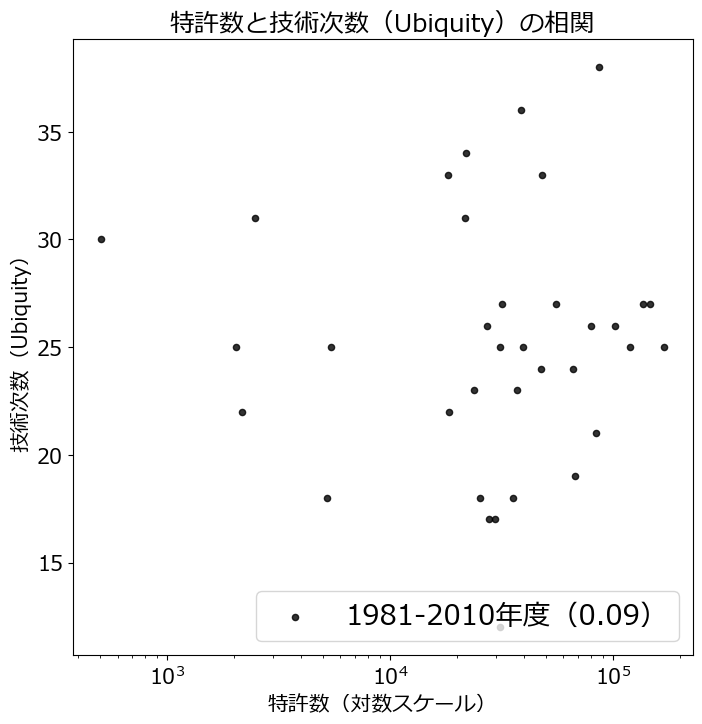

1981-2010 -0.398


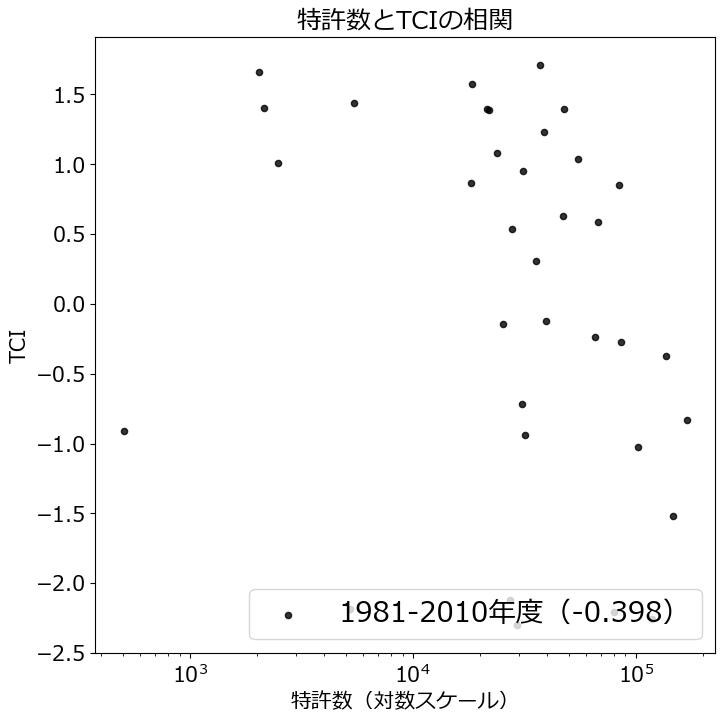

1981-2010 0.223


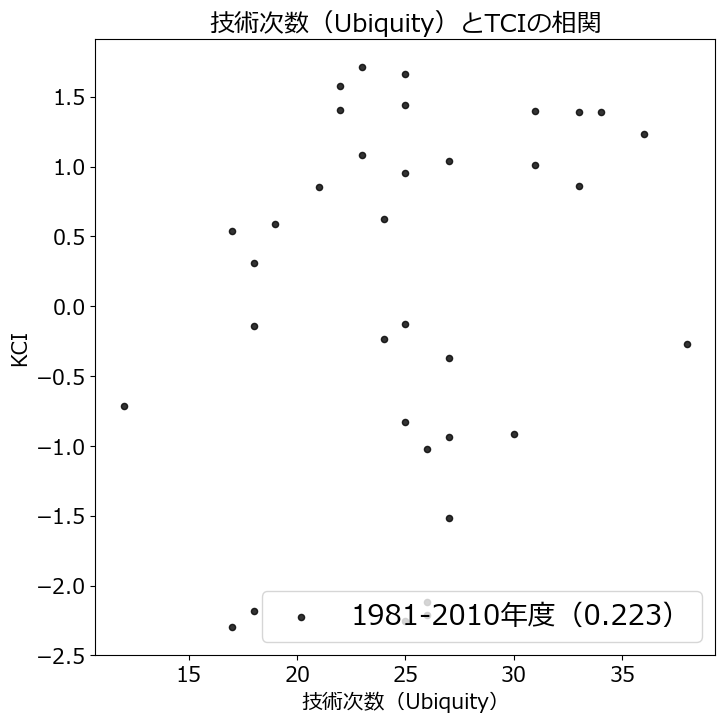

1981-2010 0.147


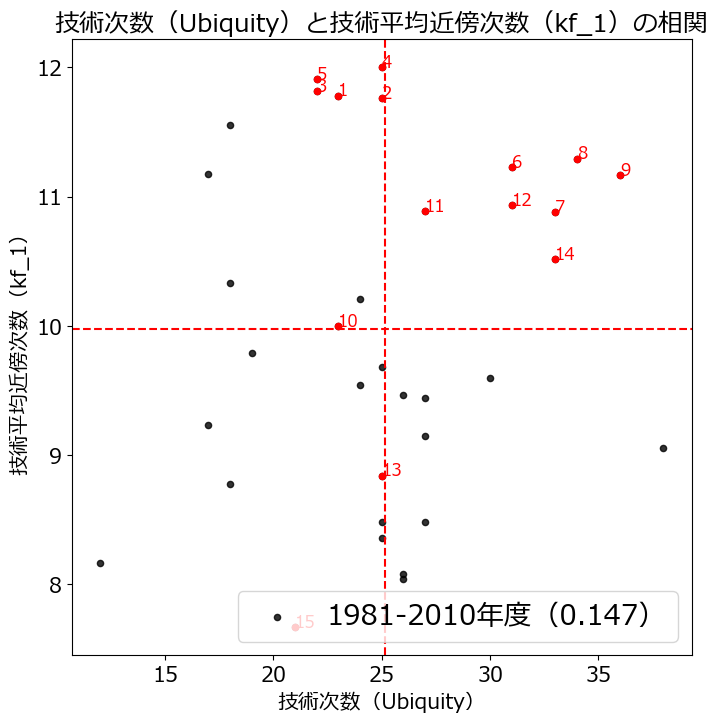

In [27]:
df_dict = {}
combi_dict = {# ind: [x, y, title, xlabel, ylabel, legend_loc]
              1: ['reg_num', 'ubiquity', '特許数と技術次数（Ubiquity）の相関', '特許数（対数スケール）', '技術次数（Ubiquity）', 'lower right'], 
              2: ['reg_num', 'tci', '特許数とTCIの相関', '特許数（対数スケール）', 'TCI', 'lower right'], 
              3: ['ubiquity', 'tci', '技術次数（Ubiquity）とTCIの相関', '技術次数（Ubiquity）', 'KCI', 'lower right'], 
              4: ['ubiquity', 'ki_1', '技術次数（Ubiquity）と技術平均近傍次数（kf_1）の相関', '技術次数（Ubiquity）', '技術平均近傍次数（kf_1）', 'lower right']
              }

for i, combi in combi_dict.items():
    fig, ax = plt.subplots(figsize=(8, 8))
    period = f'{year_start}-{year_end}'
    corr_num = round(df[df[f'{ar}_{year_style}_period']==period][combi[0]].corr(df[df[f'{ar}_{year_style}_period']==period][combi[1]]), 3)
    print(period, corr_num)
    ax.scatter(df[df[f'{ar}_{year_style}_period']==period][combi[0]], 
                df[df[f'{ar}_{year_style}_period']==period][combi[1]], s=20, 
                alpha=0.8, label=f'{period}年度（{corr_num}）', color='black')
    if i == 4:
        ax.axvline(x=df[df[f'{ar}_{year_style}_period']==period][combi[0]].mean(), color='red', linestyle='--')
        ax.axhline(y=df[df[f'{ar}_{year_style}_period']==period][combi[1]].mean(), color='red', linestyle='--')
    ax.set_title(combi[2])
    if combi[0] in ['reg_num']: ax.set_xscale('log')
    if combi[1] in ['reg_num']: ax.set_yscale('log')
    x_min = df[(df[f'{ar}_{year_style}_period']==period)][combi[0]].min()
    x_2smallest = df[(df[f'{ar}_{year_style}_period']==period)][combi[0]].nsmallest(2).iloc[1]
    y_2smallest = df[(df[f'{ar}_{year_style}_period']==period)][combi[1]].nsmallest(2).iloc[1]
    if i == 4: 
        # ax.text(x_min-1,
        #         df[(df[f'{ar}_{year_style}_period']==period)&(df[combi[0]]==x_min)][combi[1]].values[0]-0.5, 
        #         df[(df[f'{ar}_{year_style}_period']==period)&(df[combi[0]]==x_min)]['right_person_name'].values[0], 
        #         fontsize=15, color='red')
        # ax.text(x_min-1,
        #         df[(df[f'{ar}_{year_style}_period']==period)&(df[combi[0]]==x_2smallest)][combi[1]].values[0]-0.5, 
        #         df[(df[f'{ar}_{year_style}_period']==period)&(df[combi[0]]==x_2smallest)]['right_person_name'].values[0], 
        #         fontsize=15, color='red')
        # ax.text(df[(df[f'{ar}_{year_style}_period']==period)&(df[combi[1]]==y_2smallest)][combi[0]].values[0]-1,
        #         y_2smallest-0.5, 
        #         df[(df[f'{ar}_{year_style}_period']==period)&(df[combi[1]]==y_2smallest)]['right_person_name'].values[0], 
        #         fontsize=15, color='red')
        for i, row in df[(df[f'{ar}_{year_style}_period']==period)].sort_values('tci', ascending=False).reset_index(drop=True).iterrows():
            
        #     # if row['right_person_name'] in df[(df[f'{ar}_{year_style}_period']==period)].sort_values('kci', ascending=False).iloc[25:51,:]['right_person_name'].values:
        #     #     # ax.text(row[combi[0]], row[combi[1]]-0.5, i+1, fontsize=12, color='orange')
        #     #     if i+1!=51: ax.scatter(row[combi[0]], row[combi[1]], s=20, color='orange')
        #     # if row['right_person_name'] in df[(df[f'{ar}_{year_style}_period']==period)].sort_values('kci', ascending=False).iloc[51:76,:]['right_person_name'].values:
        #     #     # ax.text(row[combi[0]], row[combi[1]]-0.5, i+1, fontsize=12, color='green')
        #     #     ax.scatter(row[combi[0]], row[combi[1]], s=20, color='green')
        #     if row['right_person_name'] in df[(df[f'{ar}_{year_style}_period']==period)].sort_values('kci', ascending=False).tail(25)['right_person_name'].values:
        #         ax.text(row[combi[0]], row[combi[1]]-0.5, i+1, fontsize=10, color='blue')
        #         ax.scatter(row[combi[0]], row[combi[1]], s=20, color='blue')
            if row['schmoch35'] in df[(df[f'{ar}_{year_style}_period']==period)].sort_values('tci', ascending=False).head(15)['schmoch35'].values:
                ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=12, color='red')
                ax.scatter(row[combi[0]], row[combi[1]], s=20, color='red')
        
    ax.set_ylabel(combi[4])
    ax.set_xlabel(combi[3])
    ax.legend(loc=combi[5], fontsize=20)
    plt.show()
    

C:\Users\rin\AppData\Local\Temp\ipykernel_30428\2018359065.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, color_count].set_yticklabels(df[df[f'{ar}_{year_style}_period'] == period].groupby([classification])['reg_num'].sum().index, fontsize=20)
C:\Users\rin\AppData\Local\Temp\ipykernel_30428\2018359065.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, color_count].set_xticklabels([x for x in range(0, 80000+1, 20000)], fontsize=20, rotation=90)
C:\Users\rin\AppData\Local\Temp\ipykernel_30428\2018359065.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  xax2.set_xticklabels([int(i) for i in ax[0, color_count].get_xticks()], fontsize=20, rotation=90)
C:\Users\rin\AppData\Local\Temp\ipykernel_30428\2018359065.py:9: UserWa

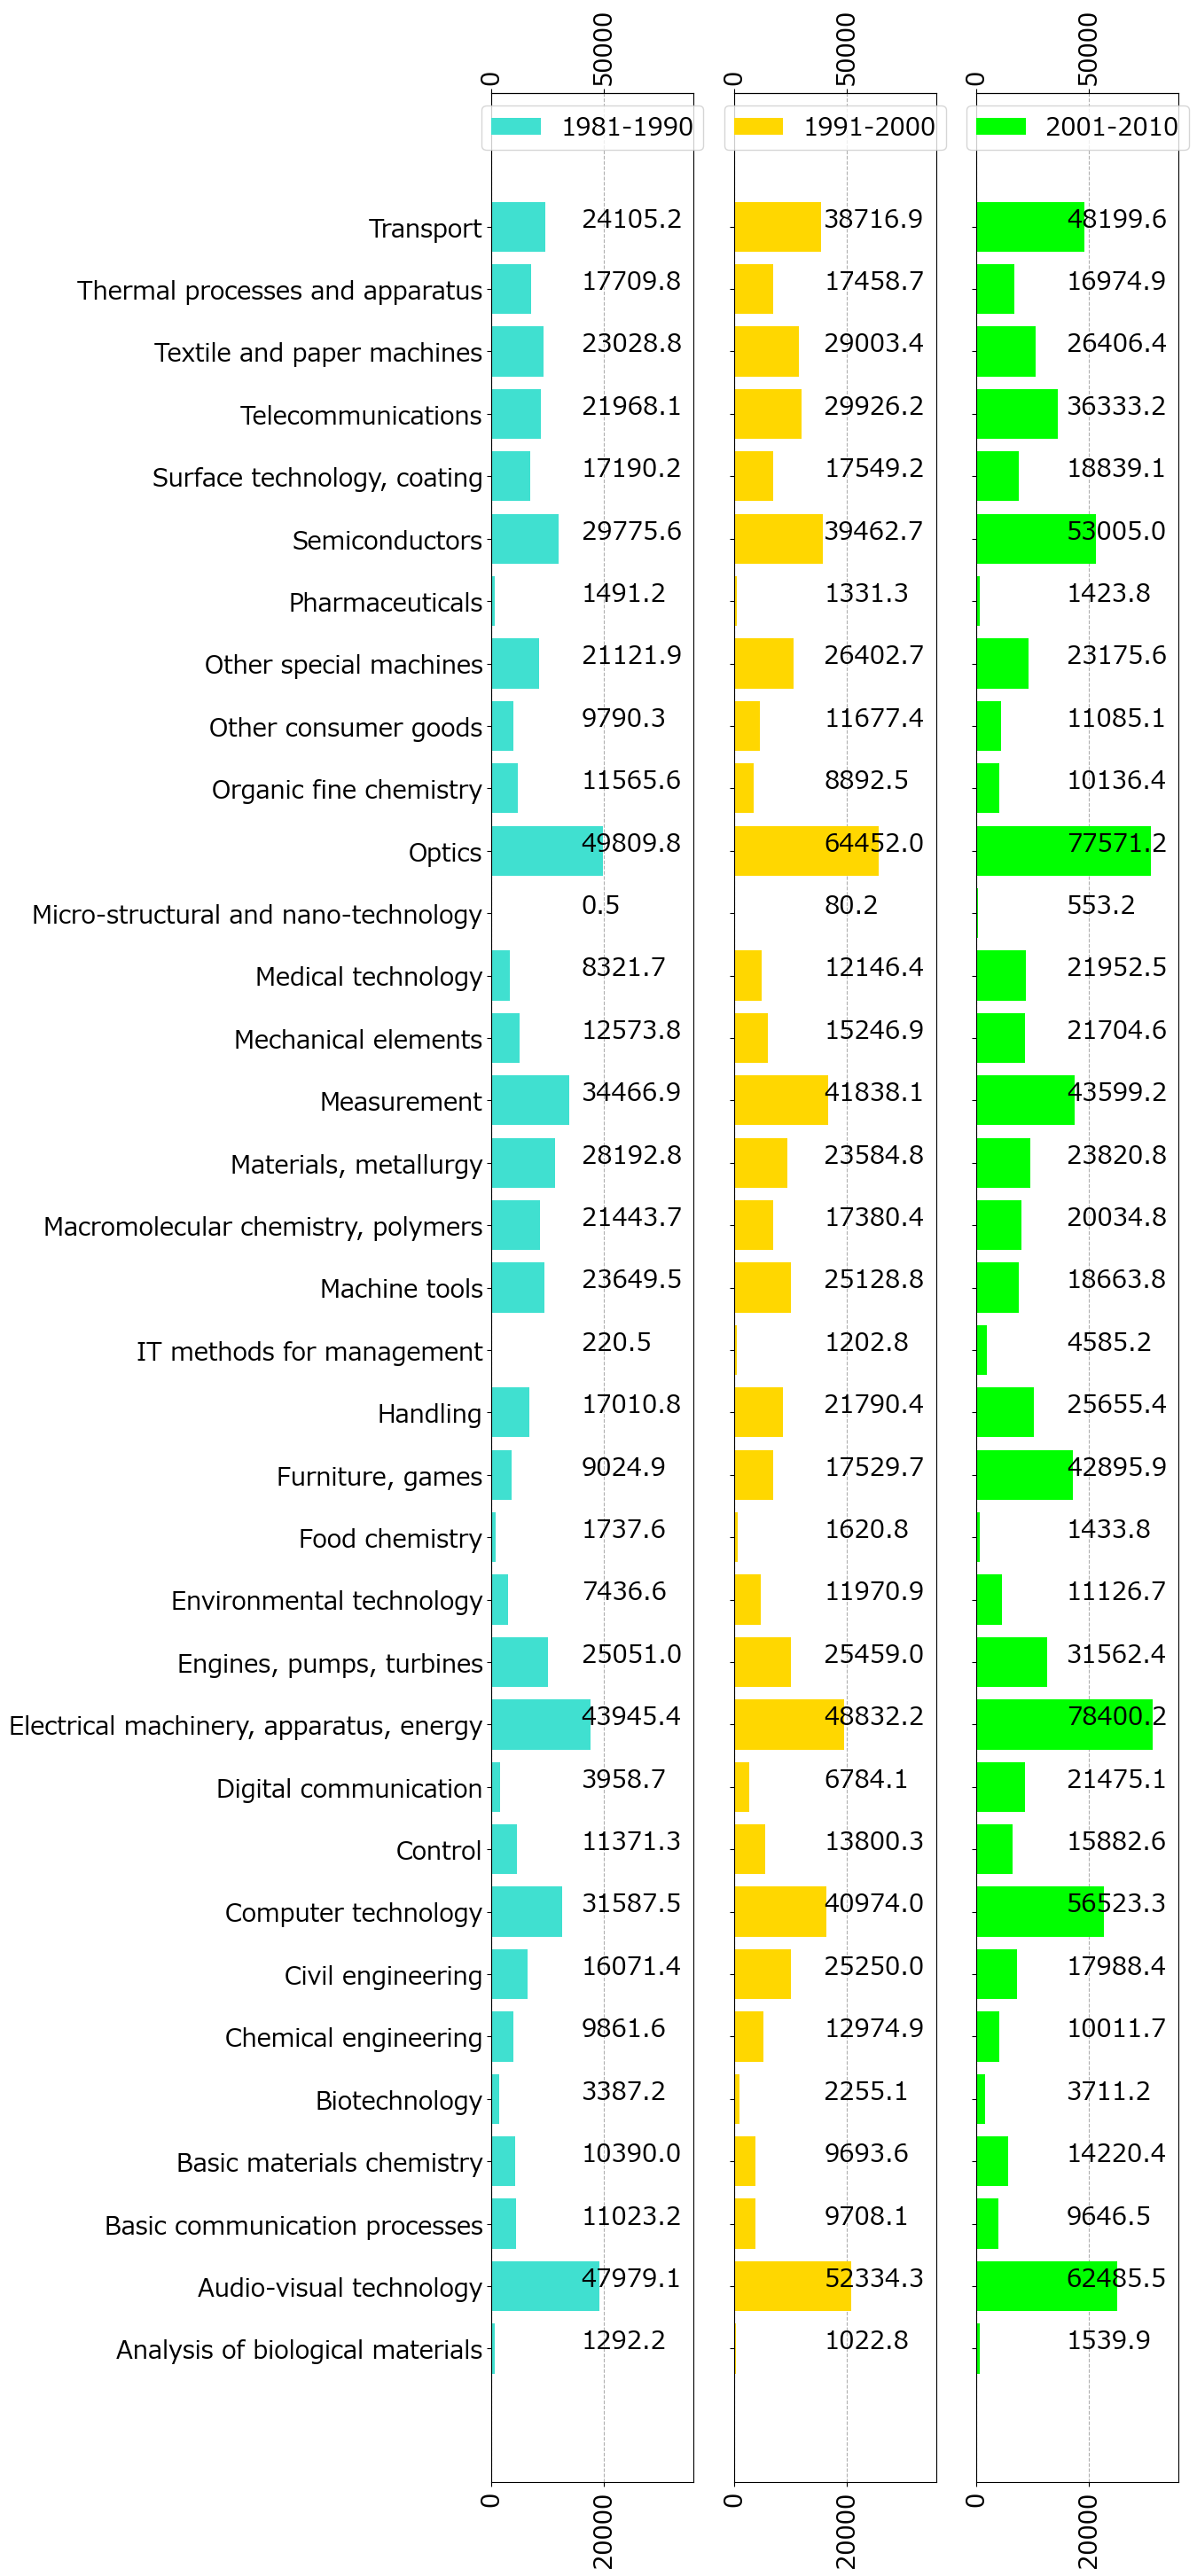

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 35), squeeze=False, sharey=True)
color_count = 0
for period in range(year_start, year_end+1, year_range):
     period = f'{period}-{period+year_range-1}'
     plot_df = df[df[f'{ar}_{year_style}_period'] == period].groupby([classification])['reg_num'].sum().sort_values('reg_num', ascending=False)
     ax[0, color_count].barh(plot_df.index, 
                              plot_df.values, 
               color=color_list[color_count], label=period)
     ax[0, color_count].set_yticklabels(df[df[f'{ar}_{year_style}_period'] == period].groupby([classification])['reg_num'].sum().index, fontsize=20)
     ax[0, color_count].set_xticklabels([x for x in range(0, 80000+1, 20000)], fontsize=20, rotation=90)
     ax[0, color_count].set_xlim(0, 90000)
     # ax[0, color_count].set_xticklabels(fontsize=15, rotation=90)
     xax2 = ax[0, color_count].secondary_xaxis('top')
     # xax2.xaxis.set_major_formatter(ptick.FuncFormatter(lambda x, _: f'{int(x):,}'))
     xax2.set_xticklabels([int(i) for i in ax[0, color_count].get_xticks()], fontsize=20, rotation=90)
     xax2.set_xlim(ax[0, color_count].get_xlim())
     ax[0, color_count].legend(fontsize=20, loc='upper center')
     ax[0, color_count].set_axisbelow(True)
     ax[0, color_count].grid(which='major', axis='x', linestyle='--')
     c_i = 0
     for c in df[df[f'{ar}_{year_style}_period'] == period].groupby([classification])['reg_num'].sum().index:
          reg_num = df[(df[f'{ar}_{year_style}_period'] == period)&(df[classification]==c)]['reg_num'].values[0]
          ax[0, color_count].text(x=40000, y=c_i, s=round(reg_num, 1), fontsize=20, color='black')
     #     ax.set_xticklabels(df[df[f'{ar}_{year_style}_period'] == period].groupby([classification])['reg_num'].sum().index, rotation=90, fontsize=15)
          c_i += 1
     color_count += 1
plt.show()


c:\Users\rin\Desktop\KCIinJapaneseFirms\notebooks\3_analysis\../../src\analysis\rank.py:315: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


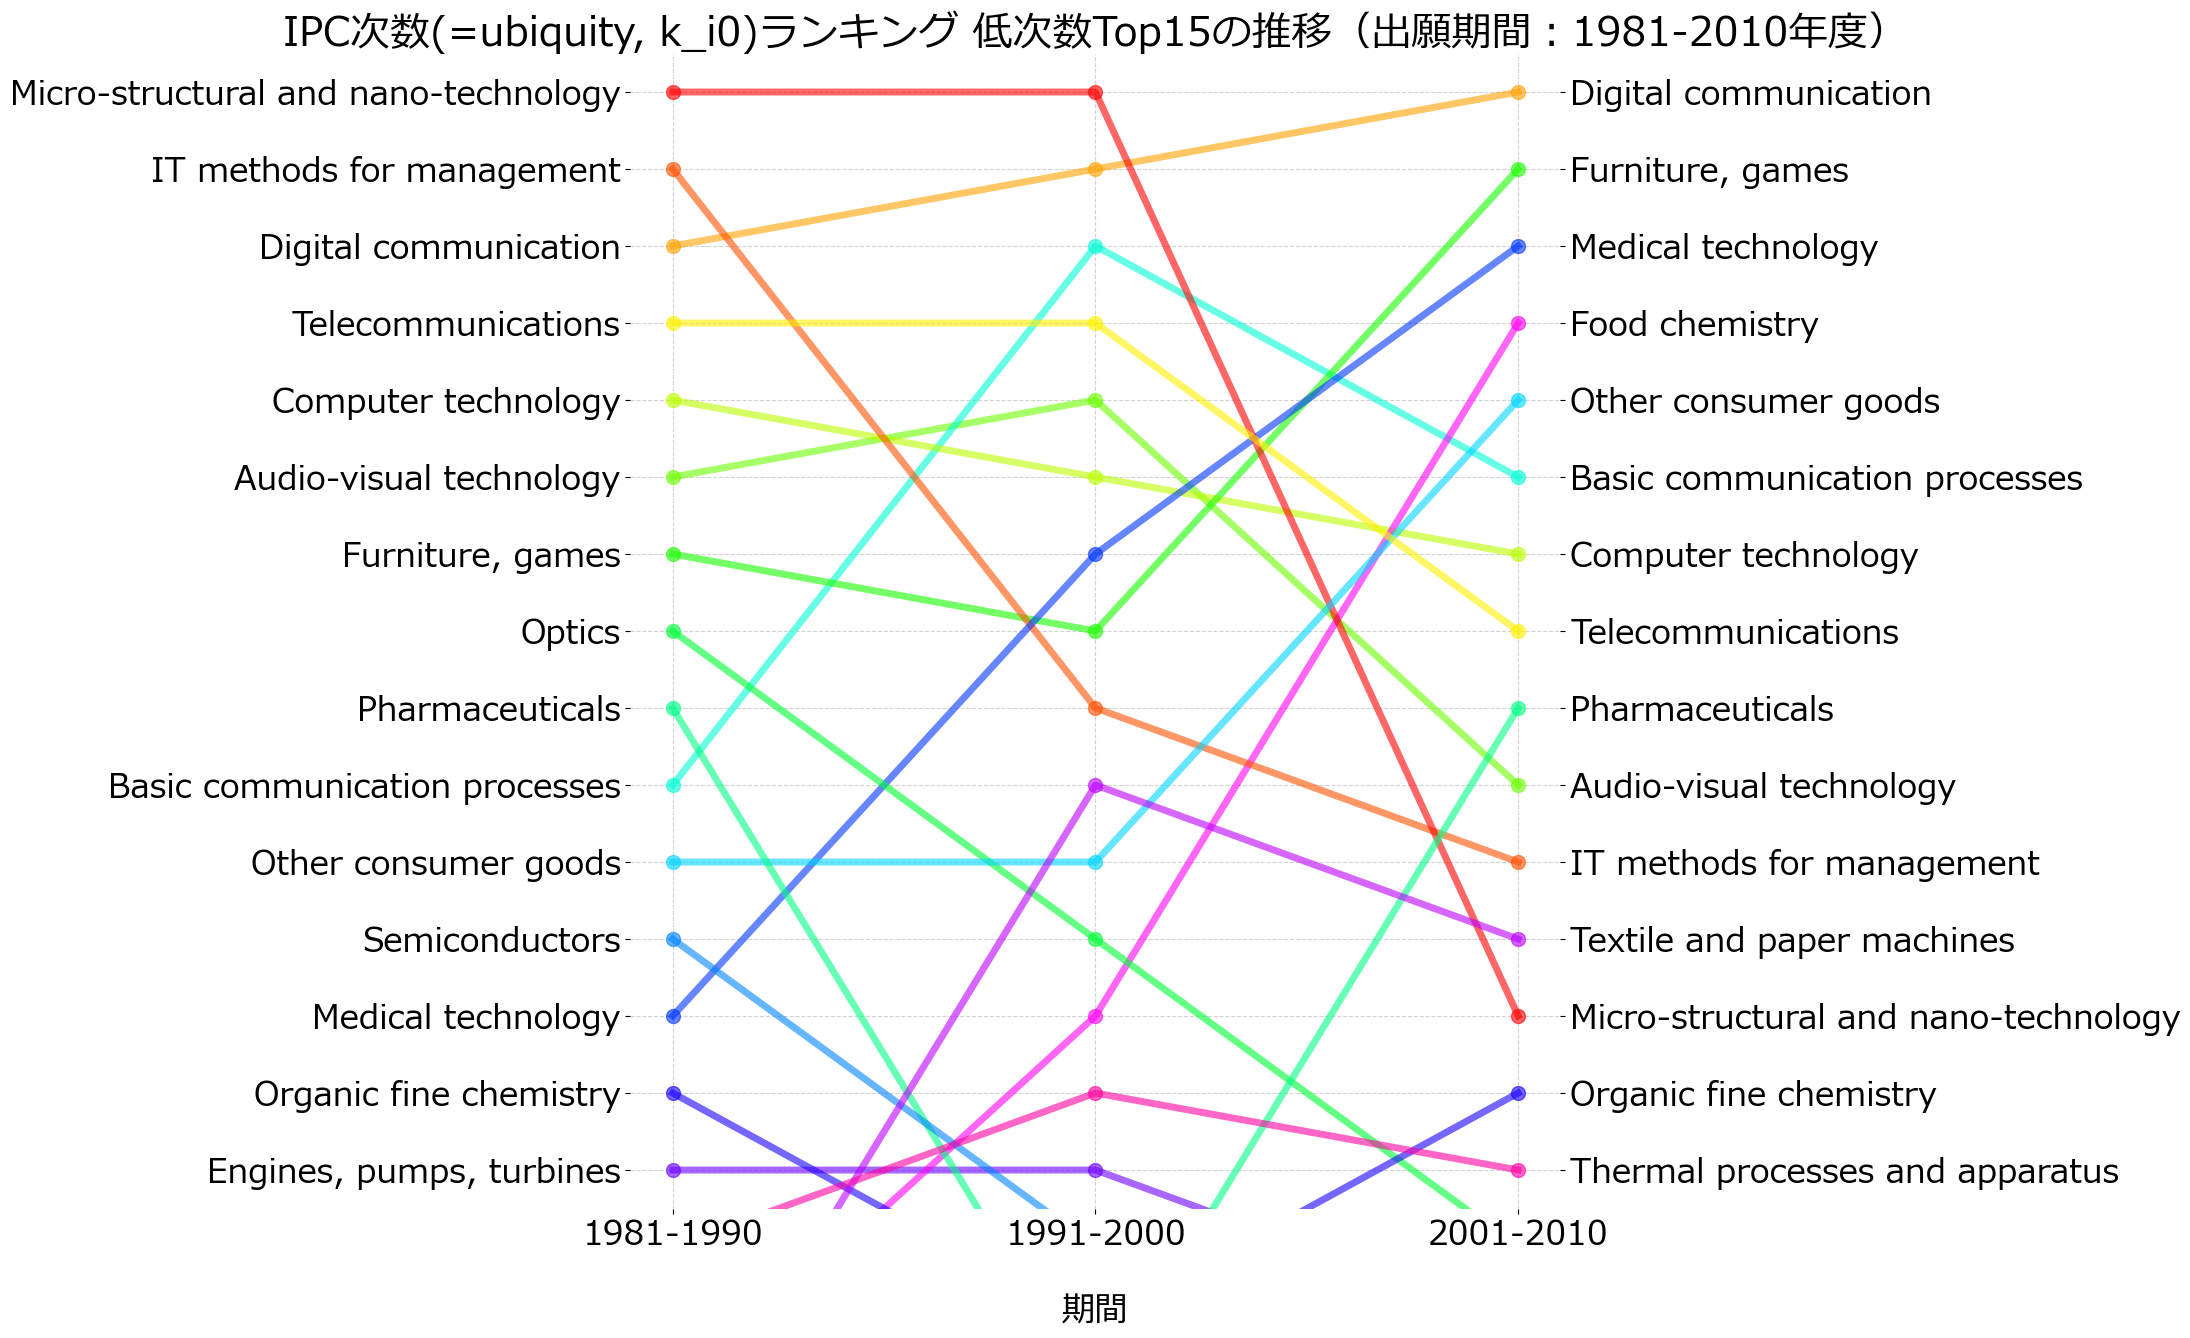

c:\Users\rin\Desktop\KCIinJapaneseFirms\notebooks\3_analysis\../../src\analysis\rank.py:315: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


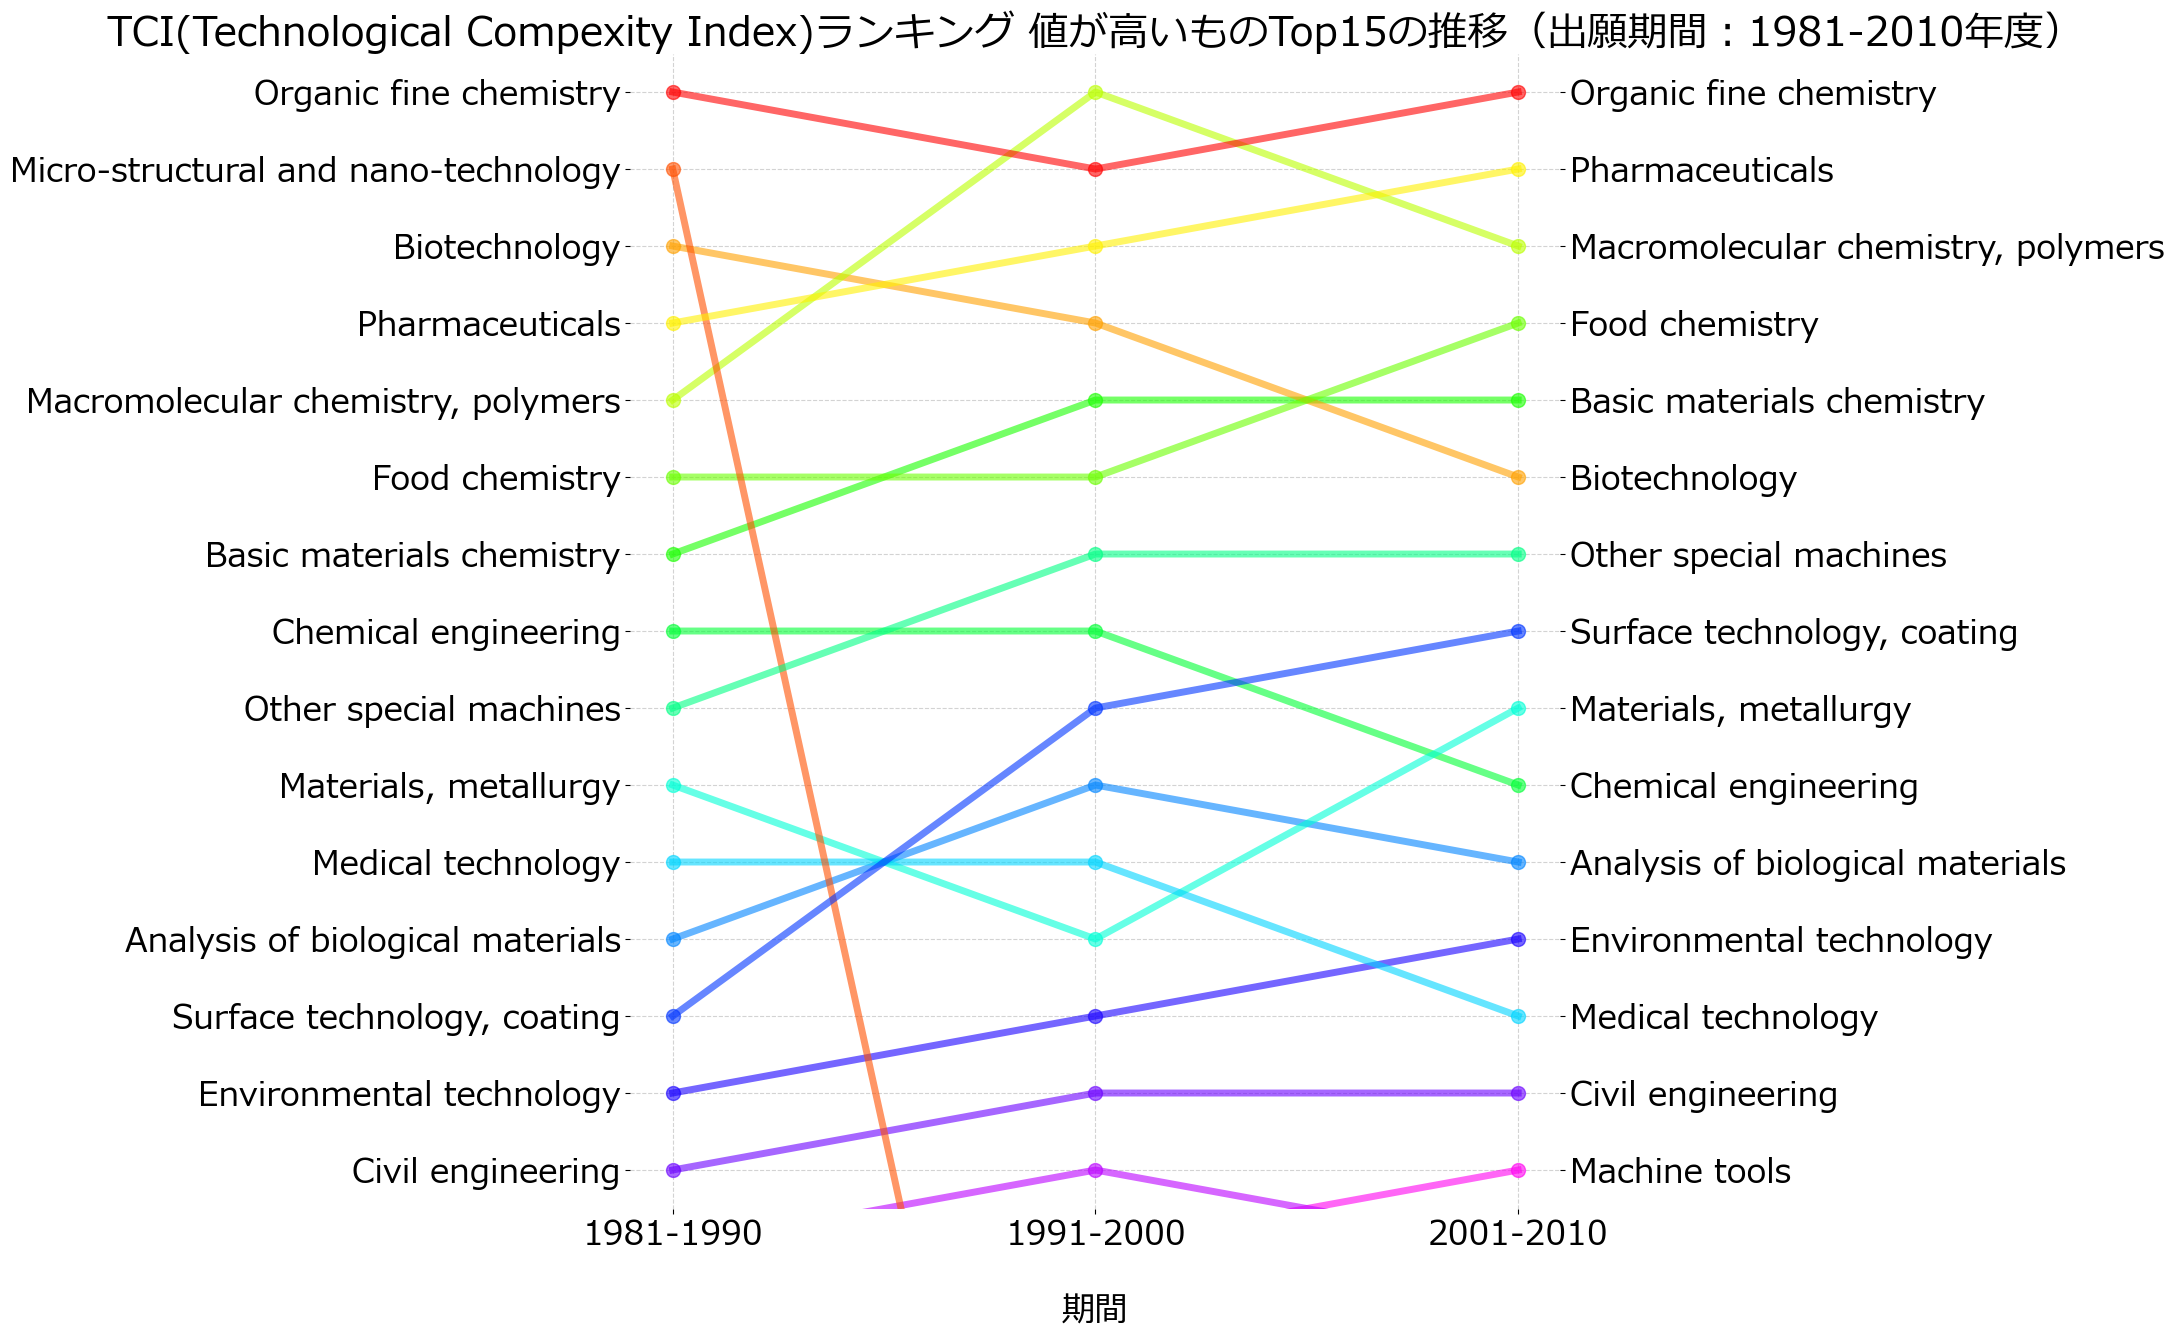

In [20]:
df_dict = {}
combi_dict = {# 1: ['right_person_name', 'Ubiquity', f'特許権者次数(=Ubiquity，k_h0)ランキング 値が小さいものTop15の推移（出願期間：{year_start}-{year_end}年度）', True], 
              # 1: ['right_person_name', '', f'特許権者次数(=Ubiquity，k_h0)ランキング 値が小さいものTop15の推移（出願期間：{year_start}-{year_end}年度）', True], 
              # 2: ['right_person_name', 'Ubiquity', f'特許権者次数(=Ubiquity，k_h0)ランキング 値が大きいものTop15の推移（出願期間：{year_start}-{year_end}年度）', False], 
              # 3: ['right_person_name', 'eci', f'KCIランキング 値が小さいものTop15の推移（出願期間：{year_start}-{year_end}年度）', True], 
              # 3: ['right_person_name', 'ipc_class_num', f'IPC数ランキング 値が大きいものTop15の推移（出願期間：{year_start}-{year_end}年度）', False], 
              # 4: ['right_person_name', 'kci', f'KCIランキング 値が大きいものTop15の推移（出願期間：{year_start}-{year_end}年度）', False], 
              5: [classification, 'ubiquity', f'IPC次数(=ubiquity, k_i0)ランキング 低次数Top15の推移（出願期間：{year_start}-{year_end}年度）', True], 
              # 6: ['ipc_class', 'ubiquity', f'IPC次数(=ubiquity, k_i0)ランキング 高次数Top15の推移（出願期間：{year_start}-{year_end}年度）', False], 
              # 7: ['ipc_class', 'pci', f'TCI(Technological Compexity Index)ランキング 値が低いものTop15の推移（出願期間：{year_start}-{year_end}年度）', True], 
              8: [classification, 'tci', f'TCI(Technological Compexity Index)ランキング 値が高いものTop15の推移（出願期間：{year_start}-{year_end}年度）', False]
              }


for i, combi in combi_dict.items():
    div_df = df[[f'{ar}_{year_style}_period']+combi[:1+1]].sort_values(by=[f'{ar}_{year_style}_period', combi[1]], ascending=[True, False]).copy()
    div_df = div_df.drop_duplicates(keep='first')
    div_df_dict = {}
    for year in range(year_start, year_end+1, year_range):
        period = f'{year}-{year+year_range-1}'
        div_df_dict[period] = div_df[div_df[f'{ar}_{year_style}_period']==period].copy()
        # display(div_df_dict[f'{year}-{year+year_range-1}'].head(15))
    if i==4:
        df['kci_rank'] = df.groupby(f'{ar}_{year_style}_period')[['kci']].rank(ascending=False, method='first').reset_index(drop=False)['kci']
        # display(c_df[c_df['right_person_name'].str.contains('三菱重工業')])
    if i > 4: fs = (12, 15)
    else: fs = (10, 12)
    # display(div_df)
    sample = vr.rank_doubleaxis(div_df_dict, 
                version='kci', 
                    rank_num=15,
                    member_col=combi[0], 
                    num_col=combi[1],
                    prop_dict={
                        'figsize': fs,
                        'xlabel': '期間',
                        'ylabel': '',
                        'title': combi[2],
                        'fontsize': 24, 
                        'year_range': year_range, 
                        'ascending': combi[3], 
                        # 'color': color_dict
                        'color': 'default'
                    })
    # plt.savefig(f'../Fig/Rank/p{p}/{combi[2]}{year_range}年ごと.png')
    plt.show()
